In [1]:
% compute noise ellipse, physics rhombus, and total ellipse given any sensor location (solid and fluid)
% use pre-computed matrix for iteration
clear;
close all;

G_solution = 4215; % INPUT
heat_flux_source = 852*1000; % INPUT [W/m2]
T_inlet_uniform = 300; % [K]

## load data for 3d temperature profile

In [2]:
digit_thousands = floor(G_solution/1000);
digit_hundreds = floor((G_solution - digit_thousands*1000)/100);
digit_tens= floor((G_solution - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname1      = ['./divisions_A_matrix/divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname1,'A_div_L_qbcs1');

% calculate 3d temperature profile
T_steady = A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;

## number grid

In [3]:
N_x_1 = 300+1; % INPUT total number of liquid grid points (including both ends) in x-direction
N_z = 100+1; % INPUT number of grid points (including both ends: inlet and outlet) in z-direction
N_x_2 = 40+1; % INPUT for solid substrate (including both ends: interface and outer wall)
N_x_tot = N_x_1 + N_x_2 - 1;
N_y = 19; % INPUT number of grid points in width direction

## INPUT sensor index (size: number sensor\*3)

In [4]:
% sensor_user_input = zeros(N_z-1,3); sensor_user_input(:,1) = 2:N_z; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all grid
% sensor_user_input = zeros(N_z-38,3); sensor_user_input(:,1) = 19:N_z-20; sensor_user_input(:,2) = N_x_1; sensor_user_input(:,3) = 1; % sensors all exp
sensor_user_input = [44,N_x_1,1; 72,N_x_1,1]; % 2 sensors

## Phi: sensor index within the grid

In [5]:
sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
number_sensor = length(sensor_index_z);
sensor_index = sensor_index_z + (sensor_index_x-1)*N_z + (sensor_index_y-1)*N_z*N_x_tot; %

Phi_location_sensor = sparse(number_sensor, N_x_tot*N_z*N_y); % within
Phi_location_sensor_z = zeros(number_sensor, N_z);
for ids=1:size(sensor_index, 1)
    Phi_location_sensor(ids, sensor_index(ids)) = 1;
    Phi_location_sensor_z(ids, sensor_index_z(ids)) = 1;
end

In [6]:
M_samples = 3; % with physics modeling uncertainty. 1st: reference, 2nd: + Pr_turb, 3rd: +vt
T_sensing_samples = zeros(number_sensor, M_samples); % [K] column matrix
T_sensing_samples = repmat(T_steady(sensor_index),1,M_samples);

## to save result

In [7]:
G_samples = zeros(M_samples, 1); % store result
heat_flux_scalar_samples = zeros(M_samples, 1);
T_centerline_samples = zeros(N_z, M_samples);

for m=1:M_samples
    fprintf('samples %d / %d \n', m, M_samples);

samples 1 / 3 
samples 2 / 3 
samples 3 / 3

## Make guess on G and heat source strength

In [8]:
    G_guess = G_solution; % [kg/m2/s]
    heat_flux_scalar_guess = heat_flux_source; % [W/m2]
    G_next = G_guess; % initialization
    heat_flux_scalar_next = heat_flux_scalar_guess; % initialization
    a_step = 0.5; % (hyperparameter) step size

    n_iteration = 30;
    Jacobian_save = zeros(length(sensor_index), 2, n_iteration); % meas, parm, iter
    a_vector_save = zeros(length(sensor_index), n_iteration);
    G_guess_save = zeros(n_iteration); % history
    heat_flux_scalar_guess_save = zeros(n_iteration);

    fprintf('original sol.: Q=%.3e, G=%.3e\n', heat_flux_source, G_solution);
    fprintf('initial guess: Q=%.3e, G=%.3e, step size=%d\n', heat_flux_scalar_guess, G_guess, a_step);

for itr=1:n_iteration
    G_guess_save(itr) = G_guess;
    heat_flux_scalar_guess_save(itr) = heat_flux_scalar_guess;

original sol.: Q=8.520e+05, G=4.215e+03
initial guess: Q=8.520e+05, G=4.215e+03, step size=5.000000e-01
original sol.: Q=8.520e+05, G=4.215e+03
initial guess: Q=8.520e+05, G=4.215e+03, step size=5.000000e-01
original sol.: Q=8.520e+05, G=4.215e+03
initial guess: Q=8.520e+05, G=4.215e+03, step size=5.000000e-01

## load precomputed calculations

In [9]:
    G_guess_floor = floor(G_guess/10)*10;
    digit_thousands = floor(G_guess_floor/1000);
    digit_hundreds = floor((G_guess_floor - digit_thousands*1000)/100);
    digit_tens= floor((G_guess_floor - digit_thousands*1000 - digit_hundreds*100)/10);
    digit_ones= floor(G_guess_floor - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
    if m == 1
        inputname3      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    elseif m == 2
        inputname3      = ['./divisions_A_matrix_Prt_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    elseif m == 3
        inputname3      = ['./divisions_A_matrix_vt_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    end
    load(inputname3,'centerline_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_Tbcs');
    f_10floor = [centerline_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_Tbcs];

    G_guess_ceil = ceil(G_guess/10)*10;
    digit_thousands = floor(G_guess_ceil/1000);
    digit_hundreds = floor((G_guess_ceil - digit_thousands*1000)/100);
    digit_tens= floor((G_guess_ceil - digit_thousands*1000 - digit_hundreds*100)/10);
    digit_ones= floor(G_guess_ceil - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
    if m == 1
        inputname4      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    elseif m == 2
        inputname4      = ['./divisions_A_matrix_Prt_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    elseif m == 3
        inputname4      = ['./divisions_A_matrix_vt_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
    end
    load(inputname4,'centerline_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_qbcs1','centerline_A_div_A_conv_A_div_L_Tbcs');
    f_10ceil = [centerline_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_qbcs1, centerline_A_div_A_conv_A_div_L_Tbcs];

    if G_guess == G_guess_floor % no interpolation
        centerline_A_div_L_qbcs1 = f_10floor(:,1);
        centerline_A_div_A_conv_A_div_L_qbcs1 = f_10floor(:,2);
        centerline_A_div_A_conv_A_div_L_Tbcs = f_10floor(:,3);
    else % interpolation
        f_interp = f_10floor + (f_10ceil-f_10floor)/(G_guess_ceil-G_guess_floor)*(G_guess-G_guess_floor);
        centerline_A_div_L_qbcs1 = f_interp(:,1);
        centerline_A_div_A_conv_A_div_L_qbcs1 = f_interp(:,2);
        centerline_A_div_A_conv_A_div_L_Tbcs = f_interp(:,3);
    end

## centerline temperature and sensing

In [10]:
    T_centerline_guess = centerline_A_div_L_qbcs1*heat_flux_scalar_guess + T_inlet_uniform;
    T_sensing_guess = zeros(number_sensor, 1); % [K] column matrix
    T_sensing_guess = T_centerline_guess(sensor_index_z);

## feature measurement

temperature difference between calculation and data


In [11]:
    a_vector = T_sensing_guess - T_sensing_samples(:,m);
    % change of parameters (from Q and G)
    b_vector1 = Phi_location_sensor_z*centerline_A_div_L_qbcs1;
    b_vector2 = -(7/8/G_guess)*Phi_location_sensor_z*(centerline_A_div_A_conv_A_div_L_qbcs1*heat_flux_scalar_guess + centerline_A_div_A_conv_A_div_L_Tbcs);

## Jacobian matrix and update parameter

In [12]:
    Jacobian = [b_vector1, b_vector2];
    Jacobian_save(:,:,itr) = Jacobian;
    a_vector_save(:,itr) = a_vector;

    p_guess = [heat_flux_scalar_guess; G_guess];
    p_next = p_guess - a_step*pinv(Jacobian)*(a_vector);

    heat_flux_scalar_next = p_next(1);
    G_next = p_next(2);

## for next iteration

In [13]:
    fprintf('iteration #%d: Q=%.3e, G=%.3e\n', itr, heat_flux_scalar_next, G_next);

    if abs(G_next-G_guess) < 1 && abs(heat_flux_scalar_guess-heat_flux_scalar_next) < 100 % stopping criteria
     fprintf('stopping criteria: G and Q converged.\n');
        break;
    else
        heat_flux_scalar_guess = heat_flux_scalar_next;
        G_guess = G_next;
    end
end
if itr == n_iteration
    fprintf('stopping criteria: set number of iteration. \n');
end

iteration #1: Q=8.520e+05, G=4.215e+03
stopping criteria: G and Q converged.
iteration #1: Q=8.651e+05, G=4.518e+03
iteration #2: Q=8.746e+05, G=4.503e+03
iteration #3: Q=8.792e+05, G=4.504e+03
iteration #4: Q=8.815e+05, G=4.504e+03
iteration #5: Q=8.827e+05, G=4.504e+03
iteration #6: Q=8.833e+05, G=4.504e+03
iteration #7: Q=8.835e+05, G=4.504e+03
iteration #8: Q=8.837e+05, G=4.504e+03
iteration #9: Q=8.838e+05, G=4.504e+03
stopping criteria: G and Q converged.
iteration #1: Q=8.655e+05, G=4.414e+03
iteration #2: Q=8.739e+05, G=4.393e+03
iteration #3: Q=8.779e+05, G=4.395e+03
iteration #4: Q=8.799e+05, G=4.395e+03
iteration #5: Q=8.809e+05, G=4.395e+03
iteration #6: Q=8.814e+05, G=4.395e+03
iteration #7: Q=8.816e+05, G=4.395e+03
iteration #8: Q=8.818e+05, G=4.395e+03
iteration #9: Q=8.818e+05, G=4.395e+03
stopping criteria: G and Q converged.

## save result

In [14]:
T_centerline_samples(:,m) = T_centerline_guess;
G_samples(m) = G_guess;
heat_flux_scalar_samples(m) = heat_flux_scalar_guess;
end

% Extract unique elements from each column
% unique_first_col = unique(sensor_user_input(:, 1));
% unique_second_col = unique(sensor_user_input(:, 2));
% unique_third_col = unique(sensor_user_input(:, 3));
%
% fprintf('\n');
% fprintf('%d sensors \n', number_sensor);
% fprintf('sensor iz: %s\n', sprintf('%g ', unique_first_col));
% fprintf('sensor ix: %s\n', sprintf('%g ', unique_second_col));
% fprintf('sensor iy: %s\n', sprintf('%g ', unique_third_col));

## for next calculation

In [15]:
G_solution = G_samples(1);
heat_flux_source = heat_flux_scalar_samples(1);
dQ_Pr_turb = heat_flux_scalar_samples(2) - heat_flux_source; % INPUT [W/m2]
dG_Pr_turb = G_samples(2) - G_solution; % INPUT [kg/m2/s]
dQ_vt = heat_flux_scalar_samples(3) - heat_flux_source; % INPUT [W/m2]
dG_vt = G_samples(3) - G_solution; % INPUT [kg/m2/s]

fprintf('solution (ref): Q=%.3e [kW/m2], G=%.3e [kg/m2/s] \n', heat_flux_source/1000, G_solution);

solution (ref): Q=8.520e+02 [kW/m2], G=4.215e+03 [kg/m2/s]

In [16]:
fprintf('+Pr_turb: dQ=%.3e [kW/m2], dG=%.3e [kg/m2/s] \n', dQ_Pr_turb/1000, dG_Pr_turb);

+Pr_turb: dQ=3.169e+01 [kW/m2], dG=2.893e+02 [kg/m2/s]

In [17]:
fprintf('+v_t: dQ=%.3e [kW/m2], dG=%.3e [kg/m2/s] \n', dQ_vt/1000, dG_vt);

+v_t: dQ=2.977e+01 [kW/m2], dG=1.801e+02 [kg/m2/s]

## analytical calculations

In [18]:
G_solution_floor = floor(G_solution/10)*10;
digit_thousands = floor(G_solution_floor/1000);
digit_hundreds = floor((G_solution_floor - digit_thousands*1000)/100);
digit_tens= floor((G_solution_floor - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution_floor - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname3      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname3,'centerline_A_div_L_qbcs1');
centerline_A_div_L_qbcs1_10floor = centerline_A_div_L_qbcs1;
T_centerline_10floor = centerline_A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;
T_sensing_10floor = Phi_location_sensor_z*T_centerline_10floor;

G_solution_ceil = ceil(G_solution/10 + sqrt(eps))*10;
digit_thousands = floor(G_solution_ceil/1000);
digit_hundreds = floor((G_solution_ceil - digit_thousands*1000)/100);
digit_tens= floor((G_solution_ceil - digit_thousands*1000 - digit_hundreds*100)/10);
digit_ones= floor(G_solution_ceil - digit_thousands*1000 - digit_hundreds*100 - digit_tens*10);
inputname4      = ['./divisions_A_matrix_centerline/centerline_divisions_A_' num2str(digit_thousands) '' num2str(digit_hundreds) '' num2str(digit_tens) '' num2str(digit_ones) '.mat'];
load(inputname4,'centerline_A_div_L_qbcs1');
centerline_A_div_L_qbcs1_10ceil = centerline_A_div_L_qbcs1;
T_centerline_10ceil = centerline_A_div_L_qbcs1*heat_flux_source + T_inlet_uniform;
T_sensing_10ceil = Phi_location_sensor_z*T_centerline_10ceil;

if G_solution == G_solution_floor % no interpolation
    centerline_A_div_L_qbcs1 = centerline_A_div_L_qbcs1_10floor;
else % interpolation
    centerline_A_div_L_qbcs1 = centerline_A_div_L_qbcs1_10floor + (centerline_A_div_L_qbcs1_10ceil-centerline_A_div_L_qbcs1_10floor)/(G_solution_ceil-G_solution_floor)*(G_solution-G_solution_floor);
end

## derivation of noise ellipse

In [19]:
b_vector1 = Phi_location_sensor_z*centerline_A_div_L_qbcs1;
b_vector2 = (T_sensing_10ceil - T_sensing_10floor)/10;

T_noise_sigma = 0.1; % INPUT
H = zeros(number_sensor, 2); % 2 is number of parameter

H(:,1) = b_vector1*1000; % first column for Q[kW]
H(:,2) = b_vector2; % second column for G
cov_estimate = T_noise_sigma^2*inv(H'*H); % covariance
% ellipse of confidence bound
confidence_interval = 0.95; % INPUT confidence interval
scale_ellipsoid = -2*log(1 - confidence_interval); % equal to chi2inv(p, 2)
[eig_vector, eig_diag] = eig(cov_estimate * scale_ellipsoid); % eig_vector gives axis of ellipsoid
[eig_diag, order] = sort(diag(eig_diag), 'descend');
eig_diag = diag(eig_diag);
eig_vector = eig_vector(:, order);

plot_angles = linspace(0, 2*pi);
plot_ellipsoid = (eig_vector * sqrt(eig_diag)) * [cos(plot_angles(:))'; sin(plot_angles(:))'];

dQ_ellipsoid = plot_ellipsoid(1,1)*1000; % [W] max change
dG_ellipsoid = plot_ellipsoid(2,1); % max change

% for contour pdf of noise uncertainty
% Define the mean and covariance matrix (example values)
pdf_mu = [heat_flux_source/1000; G_solution];  % Replace mean_Q and mean_G with your mean values
pdf_sigma_noise = cov_estimate;    % Replace with your final covariance matrix

% Create a grid of points over the range of Q and G
Q_vals = linspace(700, 1000, 500);
G_vals = linspace(3000, 5200, 500);
[Q_grid, G_grid] = meshgrid(Q_vals, G_vals);

pdf_noise = zeros(size(Q_grid)); % Initialize PDF matrix
% Calculate the bivariate Gaussian PDF at each grid point
for i = 1:length(Q_vals)
    for j = 1:length(G_vals)
        x = [Q_grid(i, j), G_grid(i, j)]';
        pdf_noise(i, j) = mvnpdf(x, pdf_mu, pdf_sigma_noise);  % Multivariate normal PDF
    end
end

sigma_Q_noise = sqrt(cov_estimate(1,1)); % Standard deviation of Q [kW/m2]
sigma_G_noise = sqrt(cov_estimate(2,2)); % Standard deviation of G [kg/m2/s]

## parallelogram

+ and \-


In [20]:
dQ_physics = [+dQ_Pr_turb + dQ_vt, +dQ_Pr_turb - dQ_vt, -dQ_Pr_turb - dQ_vt, -dQ_Pr_turb + dQ_vt]/1000; % [kW/m2]
dG_physics = [+dG_Pr_turb + dG_vt, +dG_Pr_turb - dG_vt, -dG_Pr_turb - dG_vt, -dG_Pr_turb + dG_vt];
pgon_physics = polyshape(dQ_physics + heat_flux_source/1000, dG_physics + G_solution);

## analytical UQ derivation (unit of Q \[kW\])

Q is first variable, G is second variable Pr\_turb for first vector, vt for second vector


In [21]:
Sigma_noise = cov_estimate; % covariance
M_vectors = [dQ_Pr_turb/1000, dQ_vt/1000; ...
                      dG_Pr_turb, dG_vt]; % square to rhombus transformation, match unit of [kW] and [kg/m2/s]
M_vectors_inv = inv(M_vectors);
Sigma_uniform = 1/3*eye(2); % diagonal matrix, variance from unit square [-1, +1]

Sigma_total = M_vectors*(M_vectors_inv*Sigma_noise*M_vectors_inv'+ Sigma_uniform)*M_vectors';
sigma_Q = sqrt(Sigma_total(1, 1));  % Standard deviation of Q [kW/m2]
sigma_G = sqrt(Sigma_total(2, 2));  % Standard deviation of G [kg/m2/s]

% plot total ellipse
[eig_vector_total, eig_diag_total] = eig(Sigma_total*scale_ellipsoid); % eig_vector gives axis of ellipsoid
[eig_diag_total, order_total] = sort(diag(eig_diag_total), 'descend');
eig_diag_total = diag(eig_diag_total);
eig_vector_total = eig_vector_total(:, order_total);

plot_ellipsoid_total = (eig_vector_total * sqrt(eig_diag_total)) * [cos(plot_angles(:))'; sin(plot_angles(:))'];

dQ_ellipsoid_total = plot_ellipsoid_total(1,1)*1000; % [W] max change
dG_ellipsoid_total = plot_ellipsoid_total(2,1); % max change

## for contour pdf of total uncertainties

Define the mean and covariance matrix (example values)


In [22]:
pdf_mu = [heat_flux_source/1000; G_solution];  % Replace mean_Q and mean_G with your mean values
pdf_sigma = Sigma_total;    % Replace with your final covariance matrix

% Create a grid of points over the range of Q and G
Q_vals = linspace(700, 1000, 500);
G_vals = linspace(3000, 5200, 500);
[Q_grid, G_grid] = meshgrid(Q_vals, G_vals);

pdf_total = zeros(size(Q_grid)); % Initialize PDF matrix
% Calculate the bivariate Gaussian PDF at each grid point
for i = 1:length(Q_vals)
    for j = 1:length(G_vals)
        x = [Q_grid(i, j), G_grid(i, j)]';
        pdf_total(i, j) = mvnpdf(x, pdf_mu, pdf_sigma);  % Multivariate normal PDF
    end
end

## statistics

In [23]:
area_ellipse_noise = pi*sqrt(det(Sigma_noise)); % unit: Q[kW/m2]*G[kg/m2/s]
area_ellipse_total = pi*sqrt(det(Sigma_total));
area_physics = abs(det(M_vectors));

fprintf('A(noise=%.2f K)= %.3e, A(physics uncertainty)=%.3e, A(total UQ)=%.3e [kW/m2]*[kg/m2/s] \n', T_noise_sigma, area_ellipse_noise, area_physics, area_ellipse_total);

A(noise=0.10 K)= 1.030e+03, A(physics uncertainty)=2.904e+03, A(total UQ)=4.451e+03 [kW/m2]*[kg/m2/s]

## visualization: all uncertainties


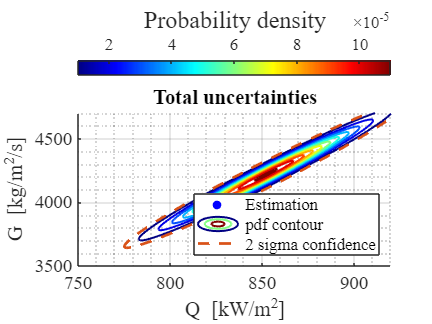

In [24]:
fontsize = 14;
figure(1)
set(gcf, 'WindowState', 'maximized');
% subplot(2,2,[1,3]); % plot the pdf contour
scatter(heat_flux_source/1000, G_solution, 40,'filled','MarkerFaceColor','blue','MarkerEdgeColor','blue','displayname',' Estimation')
hold on
contour(Q_grid, G_grid, pdf_total, 'LineWidth', 1.5,'displayname',' pdf contour');
colormap(gca, jet)
hold on
plot(heat_flux_source/1000 + plot_ellipsoid_total(1, :), G_solution + plot_ellipsoid_total(2, :),'--', 'Linewidth', 2, 'displayname',' 2 sigma confidence','color','#D95319');

% Adjust the position of the third subplot to accommodate the colorbar
h1 = colorbar('northoutside');  % Create a horizontal colorbar below the plot
h1.Label.String = 'Probability density';
h1.Label.FontSize = 18;  % Set font size for colorbar label
xlow = 750; xhigh = 920;
ylow = 3500; yhigh = 4700;
xlim([xlow xhigh])
ylim([ylow yhigh])
legend('show','location','southeast')
xlabel('Q [kW/m^2]');
ylabel('G [kg/m^2/s]');
title('Total uncertainties');
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


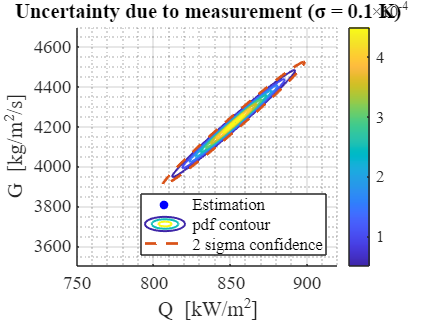

In [25]:

figure(2)
set(gcf, 'WindowState', 'maximized');
% subplot(2,2,2) % noise ellipse
scatter(heat_flux_source/1000, G_solution, 40,'filled','MarkerFaceColor','blue','MarkerEdgeColor','blue','displayname',' Estimation')
hold on
contour(Q_grid, G_grid, pdf_noise, 'LineWidth', 1.5,'displayname',' pdf contour');
colormap(gca, parula)
h2 = colorbar('eastoutside');  % Create a horizontal colorbar below the plot
% h2.Label.String = 'Probability density';

% h2.Title.String = "pdf [-]";
hold on
plot(heat_flux_source/1000 + plot_ellipsoid(1, :), G_solution + plot_ellipsoid(2, :),'--', 'Linewidth', 2, 'displayname', ' 2 sigma confidence','color','#D95319');

% ax = gca;
% ax.Position = ax.Position + [-0.05 0 0.05 0];

xlim([xlow xhigh])
ylim([ylow yhigh])
legend('show','location','southeast')
xlabel('Q [kW/m^2]')
ylabel('G [kg/m^2/s]')
titleStr = sprintf('Uncertainty due to measurement (σ = %.1f K)', T_noise_sigma);
title(titleStr);
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


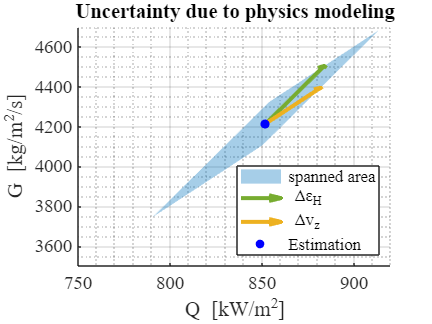

In [26]:

figure(3)
set(gcf, 'WindowState', 'maximized');
% subplot(2,2,4) % physics model
plot(pgon_physics,'Linewidth',1,'displayname',' spanned area','edgecolor','none') % physics
hold on
quiver(heat_flux_source/1000, G_solution, dQ_Pr_turb/1000, dG_Pr_turb, ...
    '-', 'color', '#77AC30', 'LineWidth', 3, 'displayname', ' Δε_H', ...
    'AutoScale', 'on', 'AutoScaleFactor', 1.0, 'MaxHeadSize', 0.10); % Set the AutoScaleFactor smaller to reduce arrow size
hold on
quiver(heat_flux_source/1000, G_solution, dQ_vt/1000, dG_vt, ...
    "-", 'color','#EDB120', 'LineWidth', 3, 'displayname',' Δv_z', ...
    'AutoScale', 'on', 'AutoScaleFactor', 1.0, 'MaxHeadSize', 0.15);
hold on
scatter(heat_flux_source/1000, G_solution, 40,'filled','MarkerFaceColor','blue','MarkerEdgeColor','blue','displayname',' Estimation')

% ax = gca;
% ax.Position = ax.Position + [-0.05 0 0.05 0];
xlim([xlow xhigh])
ylim([ylow yhigh])
legend('show','location','southeast')
xlabel('Q [kW/m^2]')
ylabel('G [kg/m^2/s]')
title('Uncertainty due to physics modeling')
set(gca,'FontSize', fontsize,'fontname','times')
grid on
grid minor